In [2]:
#!pip install rs_datasets

# Задача - Построить рекомендательную систему

##### На основе известных оценок фильмам от пользователей, научиться предсказывать другие фильмы, которые могут быть им интересны.

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Подгружаем данные - MovieLens 

In [116]:
from rs_datasets import MovieLens
ds = MovieLens(version='100k')
df = ds.ratings

print(ds.info())
print(type(df))

ratings


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116



users


,user_id,gender,age,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067



items


,item_id,title,release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,False,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False



None
<class 'pandas.core.frame.DataFrame'>


* user_id - уникальный номер пользователя
* item_id - уникальный номер видеоряда
* rating - оценка которую пользователь дал пользователь видеоряду
* timestamp - время взаимодействия пользователя и сервиса

### Этапы работы:

- Сформировать обучающую выборку; 
- Построить рекомендатор;
- Проанализировать результаты;

## Формирование обучающей выборки

* Анализ данных - смотрим максиму, минимумы, убираем Nan;
* Смотрим распределение айтемов и пользователей;
* Убираем пользователей с маленькой историей;
* Переиндексируем user_id, item_id;

In [117]:
df.max()

user_id            943
item_id           1682
rating               5
timestamp    893286638
dtype: int32

In [118]:
df.min()

user_id              1
item_id              1
rating               1
timestamp    874724710
dtype: int32

In [119]:
# Смотрим распределение айтемов и пользователей
def plot_interactions_histogram(data_frame):
    data_frame.groupby('user_id').size().hist(bins=50)
    plt.title('Histogram of interactions per user')
    plt.xlabel('Number of interactions')
    plt.ylabel('Number of movies')
    plt.show()

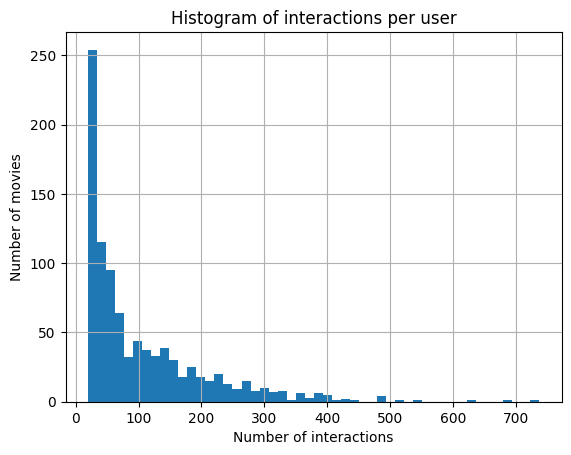

In [120]:
plot_interactions_histogram(df)

### Что говорит диаграмма?

- Много пользователей, у которах история меньше 50 фильмов (Это много или мало?);



In [121]:
# Группируем по userId и фильтруем
filtered_users = df.groupby('user_id').filter(lambda x: len(x) >= 100)[:10000]

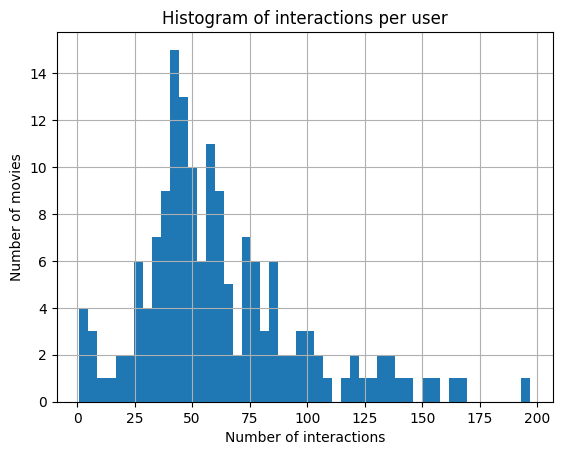

In [122]:
plot_interactions_histogram(filtered_users)

In [123]:
np.unique(filtered_users.user_id.values)

array([  1,   5,   6,   7,  10,  11,  13,  15,  16,  18,  21,  22,  23,
        26,  38,  42,  43,  44,  49,  56,  57,  58,  59,  60,  62,  64,
        70,  72,  82,  83,  85,  87,  90,  92,  94,  95,  99, 102, 104,
       109, 110, 116, 119, 125, 128, 130, 141, 144, 145, 151, 152, 158,
       159, 160, 174, 177, 178, 181, 184, 188, 189, 193, 194, 197, 198,
       200, 201, 207, 210, 213, 214, 216, 221, 222, 223, 224, 230, 233,
       234, 236, 239, 244, 246, 249, 250, 254, 256, 262, 263, 264, 267,
       268, 269, 270, 271, 276, 279, 280, 286, 290, 291, 292, 293, 294,
       295, 296, 297, 298, 299, 301, 303, 305, 307, 308, 311, 312, 313,
       314, 318, 320, 321, 325, 326, 327, 328, 330, 332, 334, 336, 339,
       342, 343, 344, 345, 346, 347, 354, 360, 361, 363, 373, 374, 378,
       379, 380, 381, 385, 387, 389, 391, 392, 393, 394, 397, 398, 399,
       401, 405, 406, 407, 409], dtype=int32)

In [124]:
np.unique(filtered_users.item_id.values)

array([   1,    2,    3, ..., 1543, 1578, 1582], dtype=int32)

### Переиндексуем пользователей и видео

In [125]:
# Переиндексация колонки
filtered_users['user_id'] = filtered_users['user_id'].rank(method='dense').astype(int)
# Переиндексация колонки
filtered_users['item_id'] = filtered_users['item_id'].rank(method='dense').astype(int)

In [126]:
np.unique(filtered_users.user_id.values)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161])

In [127]:
sorted_df = filtered_users.sort_values(by='timestamp')

### Разбиваем на обучающую и тестовую выборку

In [128]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sorted_df, test_size=0.2, random_state=42)

* Что не так с таким разбиением выборки? 

(нужно, чтобы в тестовой и тренировочной выборке были одни и те же айтемы)

* Как понять что в тестовой выборке и тренировочной айтемы полностью пересекаются?

In [154]:
# Делим уникальные item_id на обучающие и тестовые
train_items, test_items = train_test_split(sorted_df['user_id'].unique(), test_size=0.2, random_state=42)

# Извлекаем строки из исходного датафрейма на основе разделенных item_id
train_df = sorted_df[sorted_df['user_id'].isin(train_items)]
test_df = sorted_df[sorted_df['user_id'].isin(test_items)]


In [155]:
list(set(test_df.item_id) - set(train_df.item_id))

[384,
 1280,
 1281,
 1155,
 390,
 780,
 145,
 1045,
 1048,
 1051,
 37,
 429,
 950,
 1081,
 1209,
 445,
 1217,
 1090,
 1092,
 1094,
 967,
 1238,
 1244,
 1245,
 990,
 1246,
 865,
 1249,
 1251,
 874,
 759,
 1262,
 624,
 1136,
 1265,
 1015,
 1149]

In [156]:
black_list_test = list(set(test_df.item_id) - set(train_df.item_id))
black_list_train = list(set(train_df.item_id) - set(test_df.item_id))

In [157]:
test_df = test_df.drop(test_df[test_df['item_id'].isin(black_list_test)].index)
train_df = train_df.drop(train_df[train_df['item_id'].isin(black_list_train)].index)

In [158]:
print(train_df)

      user_id  item_id  rating  timestamp
5211       43      274       5  874774575
6300       43      841       3  874774575
5481       43      234       5  874774956
261        43      236       5  874775038
4635       43      617       4  874775185
...       ...      ...     ...        ...
5322       61     1044       5  893266074
8513       61      476       5  893266105
8883       61      596       4  893266204
2988       61       30       4  893266205
4659       61      980       5  893266251

[6673 rows x 4 columns]


## Реализуем рекомендатор

#### Разбор алгоритма knn

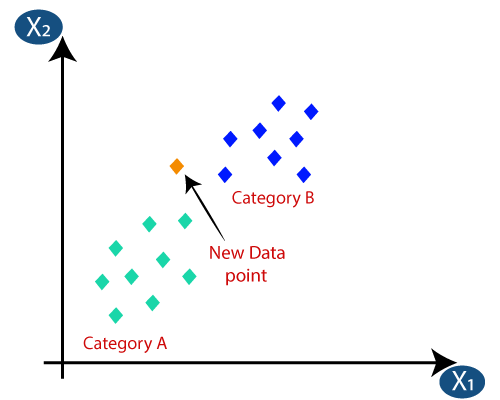

#### Реализация

Постановка задачи:

* Каждый пользователь - вектор его отношений ко всем имеющимся в данных айтемам;
* Ответ модели - усредненный вектор по ближайшим пользователям 

Реализация:

1 - Построить матрицу, user_id X item_id, принимающую значения от 0 - 5. Оценка видеоряду от пользователя.

2 - Поиск ближайших соседей для нового пользователя

3 - Получение списка рекомендаций

In [159]:
import numpy as np
import pandas as pd

# Функция для вычисления косинусного расстояния
def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

# KNN реализация
def knn_recommendations(user_id, data_frame_train, data_frame_test, k=5):
    user_item_matrix_train = data_frame_train.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    user_item_matrix_test = data_frame_test.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    
   # print(user_item_matrix_train.shape)
   # print(user_item_matrix_test.shape)
    target_user_vector = user_item_matrix_test.loc[user_id].values
    
    # Вычисление косинусного расстояния от целевого пользователя до всех остальных
    similarities = {}
    for user, row in user_item_matrix_train.iterrows():
        if user != user_id:
            similarity = cosine_similarity(target_user_vector, row.values)
            similarities[user] = similarity
    
    # Сортировка пользователей по косинусному расстоянию
    sorted_users = sorted(similarities, key=similarities.get, reverse=True)
    
    # Выборка k ближайших пользователей
    nearest_users = sorted_users[:k]

    # Получение рекомендаций на основе предпочтений этих пользователей
    recommended_movies = user_item_matrix_train.loc[nearest_users].mean().sort_values(ascending=False).index
    
    # Уберите фильмы, которые уже были просмотрены целевым пользователем
    #watched_movies = set(data_frame[data_frame['user_id'] == user_id]['item_id'])
    #recommendations = [movie for movie in recommended_movies if movie not in watched_movies]
    
    return recommended_movies

### Анализируем результаты

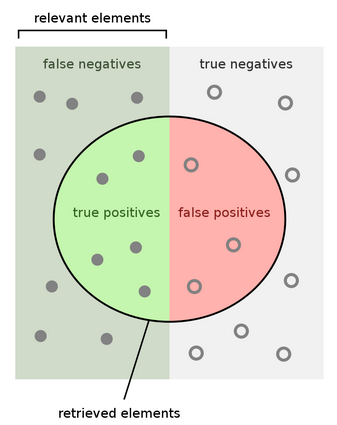

In [160]:
def precision_at_k(predictions, true_items, k):
    relevant_items = set(true_items)
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in relevant_items])
    return num_relevant / k

def recall_at_k(predictions, true_items, k):
    relevant_items = set(true_items)
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in relevant_items])
    
    return num_relevant / len(relevant_items)

# Оценка качества KNN
def evaluate_knn(user_id, train_df, test_df, top_k = 10, k_neighbours = 5):
    true_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()
    recommendations = knn_recommendations(user_id, train_df, test_df, k=k_neighbours)
    prec_at_k = precision_at_k(recommendations, true_items, top_k)
    rec_at_k = recall_at_k(recommendations, true_items, top_k)
    
    return prec_at_k, rec_at_k

In [161]:
def average_precision_and_recall(train_df, test_df, top_k = 10, k_neighbours = 5):
    all_users = test_df['user_id'].unique()
    
    total_precision = 0
    total_recall = 0
    num_users = 0
    
    for user_id in all_users:
        try:
            prec_at_k, rec_at_k = evaluate_knn(user_id, train_df, test_df, top_k, k_neighbours)
            total_precision += prec_at_k
            total_recall += rec_at_k
            num_users += 1
        except Exception as e:
            print(e)
            continue  # Это может быть полезно, если для каких-то пользователей нет рекомендаций или истинных элементов
    
    avg_precision = total_precision / num_users
    avg_recall = total_recall / num_users
    
    return avg_precision, avg_recall

In [162]:
precission, recall = average_precision_and_recall(train_df, train_df, top_k = 10, k_neighbours = 7)

print(f"Average Precision@K: {precission:.4f}")
print(f"Average Recall@K: {recall:.4f}")

Average Precision@K: 0.4609
Average Recall@K: 0.1268


In [163]:
precission, recall = average_precision_and_recall(train_df, test_df, top_k = 10, k_neighbours = 5)

print(f"Average Precision@K: {precission:.4f}")
print(f"Average Recall@K: {recall:.4f}")

Average Precision@K: 0.4182
Average Recall@K: 0.0831


#### Почему если передавать тренировочную выборку не получается 1 ?
#### Как интерпретировать Precision ?
#### Как интерпретировать Recall ?


### Use sklearn

In [185]:
from sklearn.neighbors import NearestNeighbors

def train_knn(data_frame, n_neighbors=5):
    user_item_matrix = data_frame.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors + 1)  # +1 чтобы убрать самого пользователя из списка соседей
    model_knn.fit(user_item_matrix)
    return model_knn, user_item_matrix

def get_recommendations(user_id, model_knn, user_item_matrix):

    distances, indices = model_knn.kneighbors(user_item_matrix_test.loc[user_id].values.reshape(1, -1))
    closest_users = user_item_matrix.index[indices.flatten()]
    recommended_movies = user_item_matrix.loc[closest_users].mean().sort_values(ascending=False).index
    return recommended_movies

# Функции оценки
def precision_at_k(predictions, true_items, k):
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in true_items])
    return num_relevant / k

def recall_at_k(predictions, true_items, k):
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in true_items])
    return num_relevant / len(true_items)

def evaluate_for_user(user_id, model_knn, user_item_matrix, test_df, k=5):
    recommendations = get_recommendations(user_id, model_knn, user_item_matrix)
    true_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()
    
    prec_at_k = precision_at_k(recommendations, true_items, 10)
    rec_at_k = recall_at_k(recommendations, true_items, 10)
    
    return prec_at_k, rec_at_k

def average_precision_and_recall_for_all(model_knn, user_item_matrix, test_df, k=10):
    all_users = test_df['user_id'].unique()
    
    total_precision = 0
    total_recall = 0
    num_users = 0
    
    for user_id in all_users:
        #try:
            prec_at_k, rec_at_k = evaluate_for_user(user_id, model_knn, user_item_matrix, test_df, k)
            total_precision += prec_at_k
            total_recall += rec_at_k
            num_users += 1
       # except:
          #  continue
    
    avg_precision = total_precision / num_users
    avg_recall = total_recall / num_users
    
    return avg_precision, avg_recall

# Используйте эти функции, предполагая, что у вас уже есть train_df и test_df
model, user_item_matrix = train_knn(train_df)
user_item_matrix_test = test_df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

avg_prec, avg_rec = average_precision_and_recall_for_all(model, user_item_matrix, test_df)
print(f"Average Precision@K: {avg_prec:.4f}")
print(f"Average Recall@K: {avg_rec:.4f}")

Average Precision@K: 0.4909
Average Recall@K: 0.0970
